In [ ]:
# Install required libraries
!pip install torch torchvision opencv-python pillow numpy

In [ ]:
# Import libraries
import os
import random
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import cv2
import gradio as gr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path FFHQ folder
ffhq_path = '/content/drive/My Drive/FFHQ'

# Get all subfolders
all_folders = [f for f in os.listdir(ffhq_path) if os.path.isdir(os.path.join(ffhq_path, f))]

# Select 3 random folders
real_folders = ['00000', '01000']


print("Real folders:", real_folders)

# Path StyleGAN folder
stylegan_path = '/content/drive/My Drive/StyleGAN'

# Get all zip files
all_zips = [f for f in os.listdir(stylegan_path) if f.lower().endswith('.zip')]

# Select 3 random zip files
fake_zips = ['000000.zip', '001000.zip']

print("Fake zip files:", fake_zips)

Real folders: ['00000', '01000']
Fake zip files: ['000000.zip', '001000.zip']


In [ ]:
# Supported image formats
image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff', '.webp')

# Function to get all image files from a directory
def get_image_files(directory_path):
    try:
        files = os.listdir(directory_path)
        image_files = [
            os.path.join(directory_path, f)
            for f in files
            if f.lower().endswith(image_extensions)
        ]
        return image_files
    except FileNotFoundError:
        print(f"Directory not found: {directory_path}")
        return []
    except PermissionError:
        print(f"Permission denied accessing: {directory_path}")
        return []
    except Exception as e:
        print(f"Error accessing {directory_path}: {e}")
        return []

# Function to extract zip and get images
def get_images_from_zip(zip_path, extract_to='/content/temp_extract'):
    try:
        # Create extraction directory
        os.makedirs(extract_to, exist_ok=True)

        # Extract zip
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

        # Find all images recursively
        image_files = []
        for root, _, files in os.walk(extract_to):
            for file in files:
                if file.lower().endswith(image_extensions):
                    image_files.append(os.path.join(root, file))
        return image_files
    except Exception as e:
        print(f"Error processing zip {zip_path}: {e}")
        return []

# Get all real images
real_images = []
for folder in real_folders:
    folder_path = os.path.join(ffhq_path, folder)
    real_images.extend(get_image_files(folder_path))

# Get all fake images
fake_images = []
for zip_file in fake_zips:
    zip_path = os.path.join(stylegan_path, zip_file)
    fake_images.extend(get_images_from_zip(zip_path))

print(f"\nTotal real images found: {len(real_images)}")
print(f"Total fake images found: {len(fake_images)}")

if len(real_images) == 0:
    print("Warning: No real images found!")
if len(fake_images) == 0:
    print("Warning: No fake images found!")


Total real images found: 2000
Total fake images found: 3000


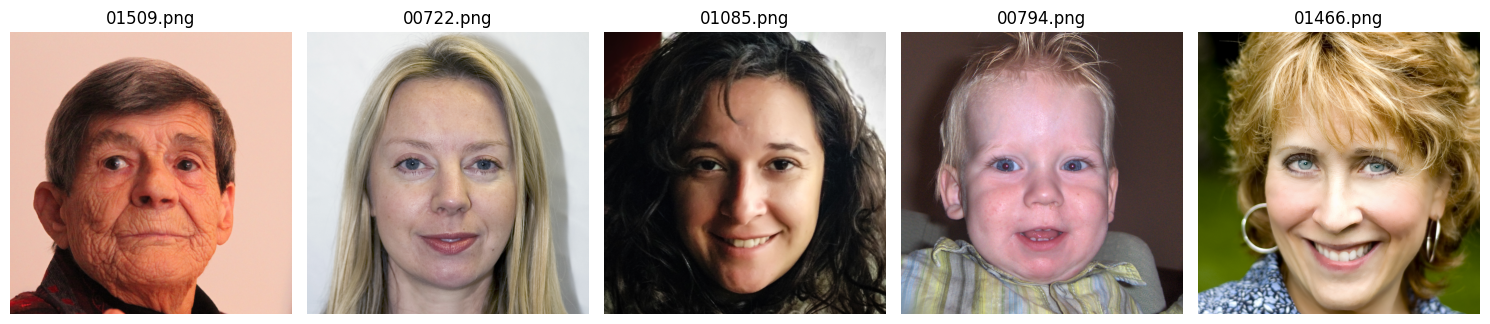

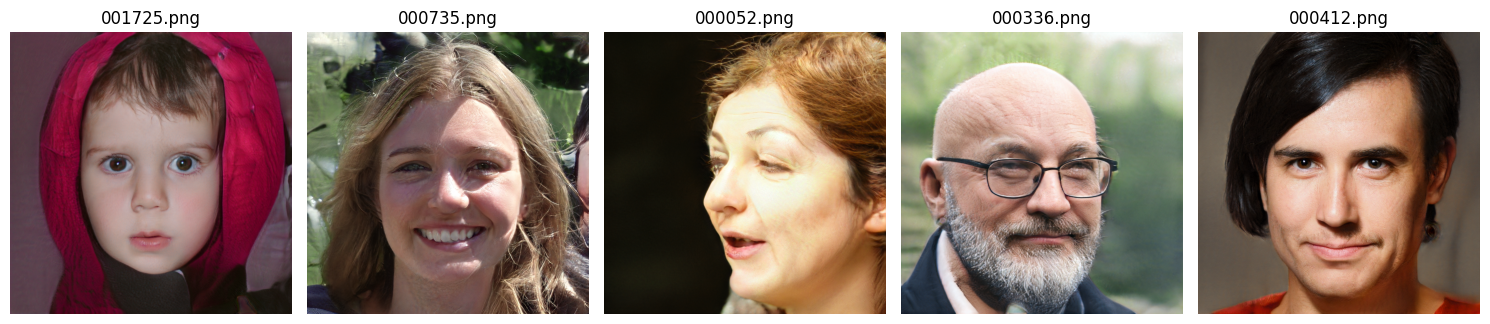

In [ ]:
# Display 5 random real images
sample_real_images = random.sample(real_images, min(5, len(real_images)))
plt.figure(figsize=(15, 5))
for i, image_path in enumerate(sample_real_images):
    image = Image.open(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
plt.tight_layout()
plt.show()

# Display 5 random fake images
sample_fake_images = random.sample(fake_images, min(5, len(fake_images)))
plt.figure(figsize=(15, 5))
for i, image_path in enumerate(sample_fake_images):
    image = Image.open(image_path)
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
plt.tight_layout()
plt.show()

In [ ]:
# Balance the dataset
num_target_images = 2000

# Check real images
if len(real_images) < num_target_images:
    print(f"Warning: Only {len(real_images)} real images available, expected {num_target_images}.")
    selected_real_images = real_images
elif len(real_images) > num_target_images:
    print(f"More real images available ({len(real_images)}), randomly selecting {num_target_images}.")
    selected_real_images = random.sample(real_images, num_target_images)
else:
    print(f"Perfect! Using all {len(real_images)} real images.")
    selected_real_images = real_images

# Check fake images
if len(fake_images) < num_target_images:
    print(f"Warning: Only {len(fake_images)} fake images available, expected {num_target_images}.")
    selected_fake_images = fake_images
elif len(fake_images) > num_target_images:
    print(f"More fake images available ({len(fake_images)}), randomly selecting {num_target_images}.")
    selected_fake_images = random.sample(fake_images, num_target_images)
else:
    print(f"Perfect! Using all {len(fake_images)} fake images.")
    selected_fake_images = fake_images

# Print final dataset composition
print(f"\nFinal dataset composition:")
print(f"Real images: {len(selected_real_images)}")
print(f"Fake images: {len(selected_fake_images)}")
print(f"Total images: {len(selected_real_images) + len(selected_fake_images)}")

# Define custom dataset for real and fake images
class DeepfakeDataset(Dataset):
    def __init__(self, real_images, fake_images, transform=None):
        self.real_images = real_images
        self.fake_images = fake_images
        self.transform = transform
        # Create image list and labels (0 for real, 1 for fake)
        self.all_images = real_images + fake_images
        self.labels = [0] * len(real_images) + [1] * len(fake_images)
        # List to store indices of valid images
        self.valid_indices = []
        self.corrupted_files = []

        # Check for valid images during initialization
        print("Checking image validity...")
        for idx in range(len(self.all_images)):
            try:
                img_path = self.all_images[idx]
                with Image.open(img_path) as image:
                    image.convert('RGB')  # Test conversion
                self.valid_indices.append(idx)
            except Exception as e:
                self.corrupted_files.append((img_path, str(e)))

        print(f"Total images: {len(self.all_images)}")
        print(f"Valid images: {len(self.valid_indices)}")
        if self.corrupted_files:
            print(f"Corrupted files found: {len(self.corrupted_files)}")
            for file_path, error in self.corrupted_files[:5]:  # Show first 5 corrupted files
                print(f"  - {file_path}: {error}")
            if len(self.corrupted_files) > 5:
                print(f"  ... and {len(self.corrupted_files) - 5} more")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Map to valid index
        valid_idx = self.valid_indices[idx]
        img_path = self.all_images[valid_idx]
        label = self.labels[valid_idx]

        try:
            with Image.open(img_path) as image:
                image = image.convert('RGB')
                if self.transform:
                    image = self.transform(image)
                return image, label
        except Exception as e:
            # This should not happen due to pre-checking, but included as a safeguard
            print(f"Error loading image {img_path}: {e}")
            # Return a black image as fallback
            if self.transform:
                black_image = Image.new('RGB', (224, 224), color='black')
                return self.transform(black_image), label
            return None, None

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Create dataset with balanced images
dataset = DeepfakeDataset(selected_real_images, selected_fake_images, transform=transform)

# Split into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print(f"\nDataset split:")
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create data loaders with custom collate function to handle None values
def custom_collate(batch):
    # Filter out None items
    batch = [item for item in batch if item[0] is not None]
    if len(batch) == 0:
        return torch.tensor([]), torch.tensor([])
    return torch.utils.data.dataloader.default_collate(batch)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)

print(f"\nData loaders created:")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

# Verify class balance in dataset
real_count = sum(1 for _, label in dataset if label == 0)
fake_count = sum(1 for _, label in dataset if label == 1)
print(f"\nClass distribution in final dataset:")
print(f"Real images (label 0): {real_count}")
print(f"Fake images (label 1): {fake_count}")
print(f"Balance ratio: {real_count/fake_count:.3f}")

Perfect! Using all 2000 real images.
More fake images available (3000), randomly selecting 2000.

Final dataset composition:
Real images: 2000
Fake images: 2000
Total images: 4000
Checking image validity...
Total images: 4000
Valid images: 4000

Dataset split:
Training set size: 3200
Test set size: 800

Data loaders created:
Training batches: 100
Test batches: 25

Class distribution in final dataset:
Real images (label 0): 2000
Fake images (label 1): 2000
Balance ratio: 1.000


In [ ]:
# Define the ResNet-based classifier with Grad-CAM hooks
class DeepfakeClassifier(nn.Module):
    def __init__(self):
        super(DeepfakeClassifier, self).__init__()
        # Load pretrained ResNet-18
        self.resnet = models.resnet18(pretrained=True)

        # Grad-CAM setup
        self.gradients = None
        self.features = None

        # Hook the feature maps and gradients
        target_layer = self.resnet.layer4[-1]  # Last convolutional layer
        target_layer.register_forward_hook(self.save_features)
        target_layer.register_backward_hook(self.save_gradients)

        # Modify the final fully connected layer for binary classification
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 1)  # Output 1 for binary classification (sigmoid)

    def save_features(self, module, input, output):
        self.features = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def forward(self, x):
        return self.resnet(x)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy with logits
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 76.9MB/s]


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch [1/10], Train Loss: 0.7370, Train Acc: 53.75%, Val Loss: 0.6976, Val Acc: 53.75%
Epoch [2/10], Train Loss: 0.6559, Train Acc: 62.09%, Val Loss: 0.7032, Val Acc: 55.00%
Epoch [3/10], Train Loss: 0.6003, Train Acc: 68.12%, Val Loss: 0.6452, Val Acc: 61.38%
Epoch [4/10], Train Loss: 0.3704, Train Acc: 83.19%, Val Loss: 0.3256, Val Acc: 86.25%
Epoch [5/10], Train Loss: 0.1678, Train Acc: 93.00%, Val Loss: 0.1598, Val Acc: 93.12%
Epoch [6/10], Train Loss: 0.0580, Train Acc: 97.72%, Val Loss: 0.1490, Val Acc: 93.62%
Epoch [7/10], Train Loss: 0.0389, Train Acc: 98.75%, Val Loss: 0.1358, Val Acc: 94.88%
Epoch [8/10], Train Loss: 0.0207, Train Acc: 99.25%, Val Loss: 0.1182, Val Acc: 95.88%
Epoch [9/10], Train Loss: 0.0186, Train Acc: 99.31%, Val Loss: 0.1025, Val Acc: 96.62%
Epoch [10/10], Train Loss: 0.0380, Train Acc: 98.56%, Val Loss: 0.1547, Val Acc: 95.38%


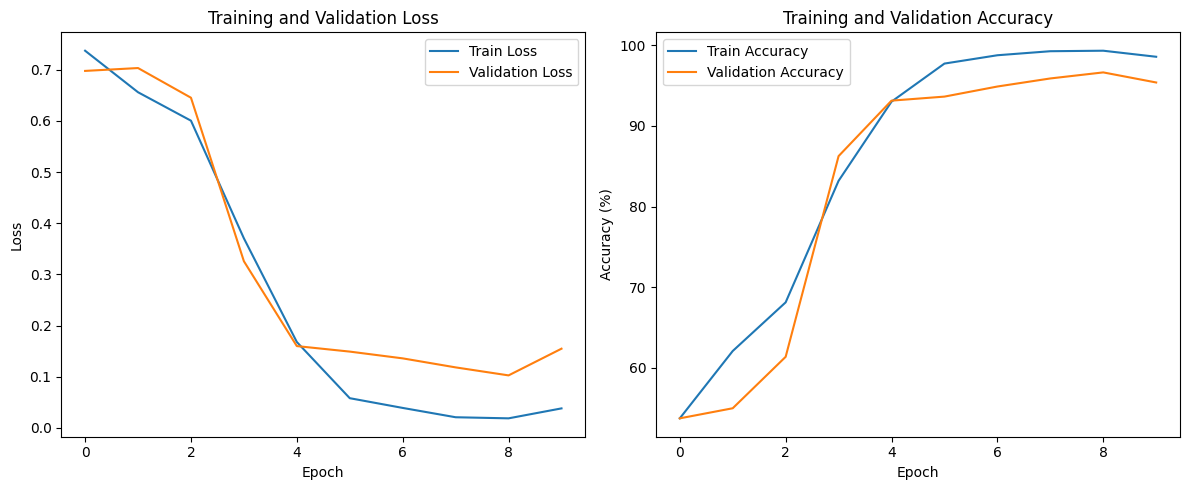

In [ ]:
# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        # Skip empty batches
        if images.size(0) == 0:
            continue
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        total_train += images.size(0)
        # Calculate training accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels).sum().item()
    epoch_loss = running_loss / total_train if total_train > 0 else float('inf')
    train_accuracy = 100 * correct_train / total_train if total_train > 0 else 0
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # Skip empty batches
            if images.size(0) == 0:
                continue
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            total_val += images.size(0)
            # Calculate validation accuracy
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels).sum().item()
    val_epoch_loss = val_loss / total_val if total_val > 0 else float('inf')
    val_accuracy = 100 * correct_val / total_val if total_val > 0 else 0
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

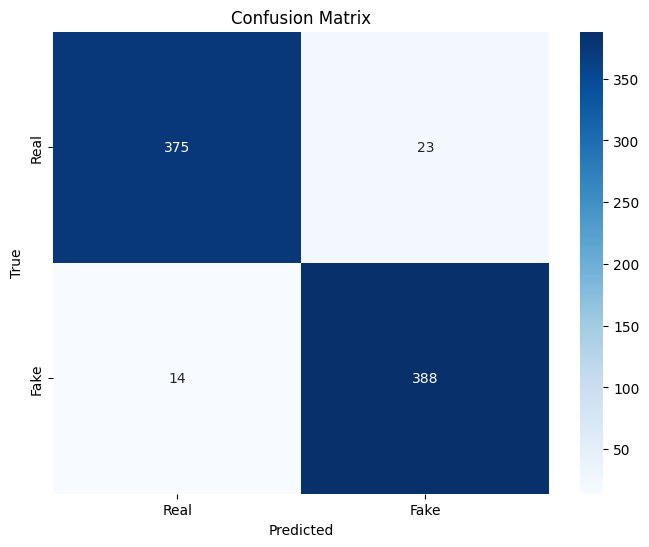

Confusion Matrix:
[[375  23]
 [ 14 388]]

Classification Report:
              precision    recall  f1-score   support

        Real       0.96      0.94      0.95       398
        Fake       0.94      0.97      0.95       402

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800

Test Accuracy: 95.38%


In [ ]:
# Evaluate the model on the test set to compute the confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        # Skip empty batches
        if images.size(0) == 0:
            continue

        # Move data to the correct device
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        # Get model outputs
        outputs = model(images)

        # Convert outputs to binary predictions (0 or 1) and flatten
        # We use .flatten() to ensure a 1D array regardless of batch size
        predicted = (torch.sigmoid(outputs) > 0.5).float().flatten().cpu().numpy()

        # Flatten the labels to a 1D array
        true_labels = labels.flatten().cpu().numpy()

        # Extend the lists
        all_preds.extend(predicted)
        all_labels.extend(true_labels)

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print confusion matrix values and classification report
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))

# Calculate and print accuracy
correct = (all_preds == all_labels).sum()
total = len(all_labels)
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

In [ ]:
# Save the model
model_path = "/content/drive/My Drive/deepfake_detection/models/resnet.pth"

checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': val_losses[-1],
}

torch.save(checkpoint, model_path)
print(f"Model saved to {model_path}")

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 4.2 MB/s 

In [ ]:
# Define the ResNet-based classifier with Grad-CAM hooks
class DeepfakeClassifier(nn.Module):
    def __init__(self):
        super(DeepfakeClassifier, self).__init__()
        # Load pretrained ResNet-18
        self.resnet = models.resnet18(pretrained=True)

        # Grad-CAM setup
        self.gradients = None
        self.features = None

        # Hook the feature maps and gradients
        target_layer = self.resnet.layer4[-1]  # Last convolutional layer
        target_layer.register_forward_hook(self.save_features)
        target_layer.register_backward_hook(self.save_gradients)

        # Modify the final fully connected layer for binary classification
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 1)  # Output 1 for binary classification (sigmoid)

    def save_features(self, module, input, output):
        self.features = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def forward(self, x):
        return self.resnet(x)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy with logits
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

model_folder_path = '/content/drive/MyDrive/deepfake_detection/models'
checkpoint_path = os.path.join(model_folder_path, 'resnet.pth')

# Initialize a new model instance on the correct device
loaded_model = DeepfakeClassifier().to(device)

# Load the saved checkpoint
try:
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Error: The checkpoint file was not found at {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load the state dictionaries into the model
    loaded_model.load_state_dict(checkpoint['model_state_dict'])

    # Set the model to evaluation mode for inference
    loaded_model.eval()

    print(f"Model loaded successfully from {checkpoint_path}")

except FileNotFoundError as e:
    print(e)
except KeyError:
    print("Error: The checkpoint file is missing the 'model_state_dict' key. Please check if the saved checkpoint is structured correctly.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully from /content/drive/MyDrive/deepfake_detection/models/resnet.pth


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import gdown
from pytorch_grad_cam.utils.image import show_cam_on_image

def get_grad_cam_visualization(model, image_tensor, image_path, category):
    # 1. Forward pass: This will populate the 'features' attribute
    # We detach the output and apply sigmoid to simulate the final prediction
    outputs = model(image_tensor)
    pred_probs = torch.sigmoid(outputs)

    # 2. Zero the gradients
    model.zero_grad()

    # 3. Backward pass to populate the 'gradients' attribute
    # We backpropagate the prediction of the target category
    one_hot_output = torch.zeros_like(pred_probs)
    one_hot_output[0][0] = pred_probs[0][0] if category == 1 else 1 - pred_probs[0][0]
    one_hot_output.backward()

    # Get the feature maps and gradients from the model's attributes
    gradients = model.gradients
    features = model.features

    # 4. Calculate Grad-CAM
    # Global average pooling on the gradients
    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

    # Multiply the feature maps by the weights
    grayscale_cam = torch.sum(weights * features, dim=1, keepdim=True)

    # Apply ReLU to get a positive heatmap
    grayscale_cam = nn.ReLU()(grayscale_cam)

    # Resize and normalize the heatmap
    grayscale_cam = torch.nn.functional.interpolate(grayscale_cam, size=(224, 224), mode='bilinear', align_corners=False)
    grayscale_cam = grayscale_cam.squeeze().detach().cpu().numpy()
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)

    # 5. Load the original image and create the overlay
    original_image = Image.open(image_path).convert('RGB')
    original_image = original_image.resize((224, 224))
    original_image_np = np.array(original_image, dtype=np.float32) / 255.0

    visualization = show_cam_on_image(original_image_np, grayscale_cam, use_rgb=True)

    return grayscale_cam, visualization

000946.jpg already exists, skipping download


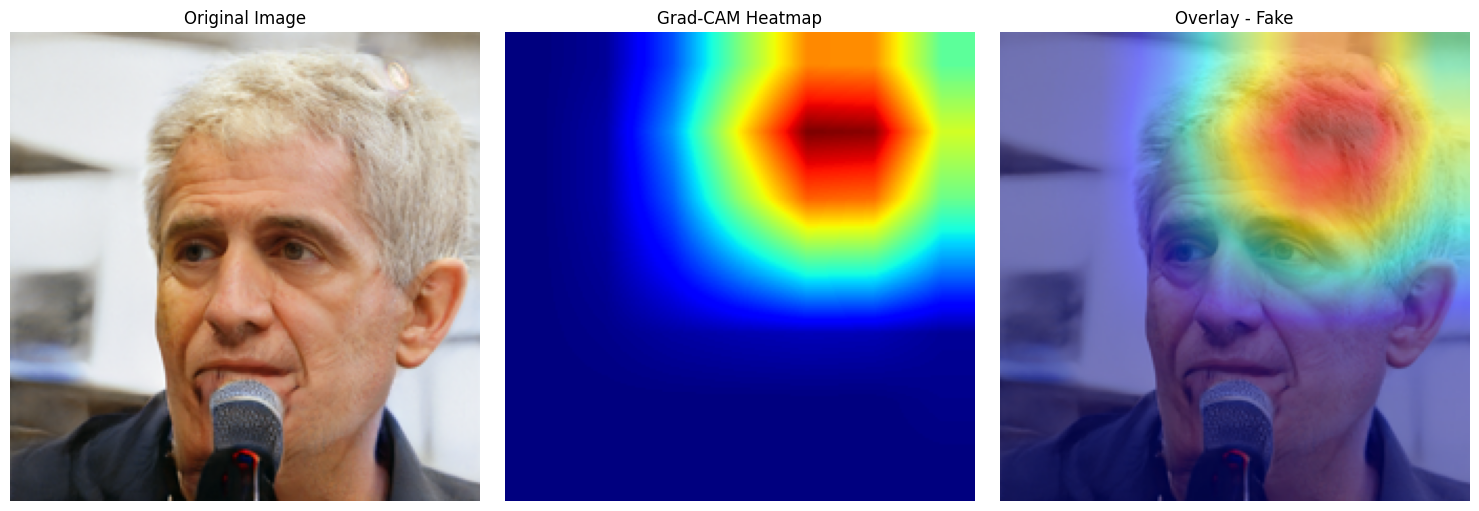

In [ ]:
model = loaded_model

image_id = "1HESPk0FBMPLDi0lheMBht6dyX6eSyx-S"
image_name = "000946.jpg"

if not os.path.exists(image_name):
    print(f"Downloading {image_name}...")
    url = f"https://drive.google.com/uc?id={image_id}"
    gdown.download(url, image_name, quiet=False)
else:
    print(f"{image_name} already exists, skipping download")

original_image = Image.open(image_name).convert('RGB')
# Resize the original image to 224x224 before passing it to the visualization function.
resized_image_for_cam = original_image.resize((224, 224))
rgb_img_float = np.float32(resized_image_for_cam) / 255
deepfake_image = rgb_img_float

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_tensor = preprocess(original_image).unsqueeze(0).to(device)
input_tensor = image_tensor.to(device)

with torch.no_grad():
  output = loaded_model(image_tensor)
  prediction = torch.sigmoid(output).item()

predicted_class = "Fake" if prediction > 0.5 else "Real"
confidence = prediction if predicted_class == "Fake" else 1 - prediction

# Generate Grad-CAM visualizations
target_category = 1 if predicted_class == "Fake" else 0

# Generate and display the Grad-CAM visualization
grayscale_cam, cam_visualization = get_grad_cam_visualization(model, image_tensor, image_name, category=target_category)

# Display the image using matplotlib or PIL
# Load the original image
original_image = Image.open(image_name).convert('RGB')
original_image = original_image.resize((224, 224))
original_image_np = np.array(original_image, dtype=np.float32) / 255.0

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the original image
axes[0].imshow(original_image_np)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot the heatmap
axes[1].imshow(grayscale_cam, cmap='jet')
axes[1].set_title('Grad-CAM Heatmap')
axes[1].axis('off')

# Plot the overlay
axes[2].imshow(cam_visualization)
axes[2].set_title(f"Overlay - {'Fake' if target_category == 1 else 'Real'}")
axes[2].axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully from /content/drive/MyDrive/deepfake_detection/models/resnet.pth
000946.jpg already exists, skipping download
Predicted class: Fake with confidence: 1.0000
Predicted category: 1
Generating CAM visualization for: GradCAM
Generating CAM visualization for: GradCAM++
Generating CAM visualization for: EigenGradCAM
Generating CAM visualization for: AblationCAM


100%|██████████| 16/16 [00:41<00:00,  2.57s/it]


Generating CAM visualization for: RandomCAM


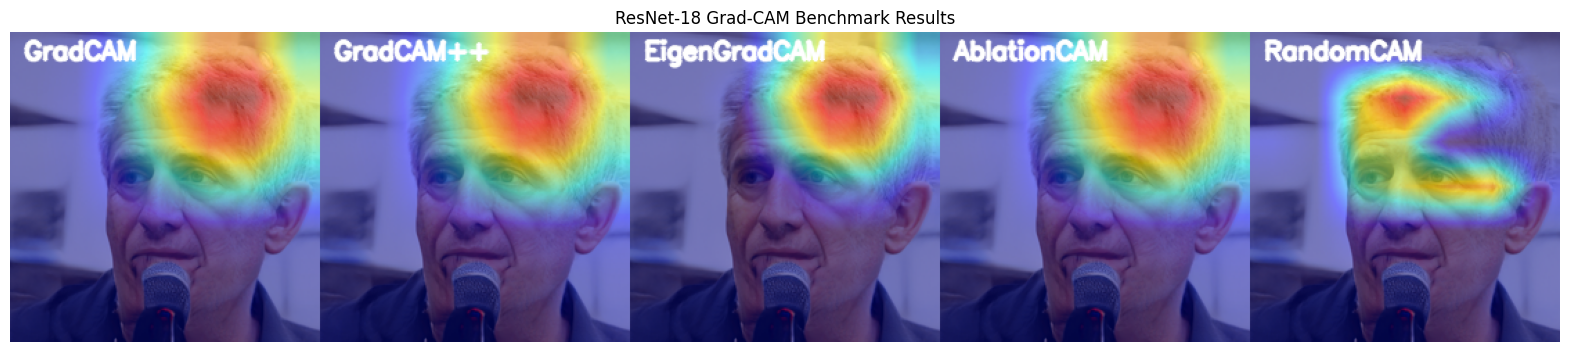

In [ ]:
import torch
import numpy as np
import cv2
import requests
from PIL import Image
import matplotlib.pyplot as plt
import gdown
import os
from torchvision import transforms
import torch.nn as nn
from torchvision import models
from google.colab import drive
from torch import optim
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, ClassifierOutputSoftmaxTarget
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.metrics.road import ROADCombined
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

drive.mount('/content/drive')

model_folder_path = '/content/drive/MyDrive/deepfake_detection/models'
checkpoint_path = os.path.join(model_folder_path, 'resnet.pth')

# Initialize a new model instance on the correct device
loaded_model = DeepfakeClassifier().to(device)

# Load the saved checkpoint
try:
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Error: The checkpoint file was not found at {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load the state dictionaries into the model
    loaded_model.load_state_dict(checkpoint['model_state_dict'])

    # Set the model to evaluation mode for inference
    loaded_model.eval()

    print(f"Model loaded successfully from {checkpoint_path}")

except FileNotFoundError as e:
    print(e)
except KeyError:
    print("Error: The checkpoint file is missing.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

image_id = "1HESPk0FBMPLDi0lheMBht6dyX6eSyx-S"
image_name = "000946.jpg"

if not os.path.exists(image_name):
    print(f"Downloading {image_name}...")
    url = f"https://drive.google.com/uc?id={image_id}"
    gdown.download(url, image_name, quiet=False)
else:
    print(f"{image_name} already exists, skipping download")

original_image = Image.open(image_name).convert('RGB')
# Resize the original image to 224x224 before passing it to the visualization function.
resized_image_for_cam = original_image.resize((224, 224))
rgb_img_float = np.float32(resized_image_for_cam) / 255
deepfake_image = rgb_img_float

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

loaded_model.eval()
loaded_model.to(device)

image_tensor = preprocess(original_image).unsqueeze(0).to(device)
input_tensor = image_tensor.to(device)

# last convolutional layer
target_layer = [loaded_model.resnet.layer4[-1]]

# Custom target for binary classification
class BinaryClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        return (model_output[0] if self.category == 1
                else -model_output[0])

def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def benchmark(model, image_tensor, image_path, target_layer, category=1):
    cam_methods = [
        ("GradCAM", GradCAM(model=model, target_layers=target_layer)),
        ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layer)),
        ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layer)),
        ("AblationCAM", AblationCAM(model=model, target_layers=target_layer)),
        ("RandomCAM", RandomCAM(model=model, target_layers=target_layer))
    ]

    targets = [BinaryClassifierOutputTarget(category=category)]
    visualizations = []

    original_image = Image.open(image_path).convert('RGB')
    original_image = original_image.resize((224, 224))
    original_image_np = np.array(original_image, dtype=np.float32) / 255.0

    for name, cam_method in cam_methods:
        print(f"Generating CAM visualization for: {name}")

        grayscale_cam = cam_method(input_tensor=image_tensor, targets=targets)[0]
        visualization = show_cam_on_image(original_image_np, grayscale_cam, use_rgb=True)

        visualization = cv2.putText(
            visualization,
            name,
            (10, 20),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 255, 255),
            2,
            cv2.LINE_AA
        )
        visualizations.append(visualization)

    final_visualization = np.hstack(visualizations)
    return Image.fromarray(final_visualization)

# Get prediction
with torch.no_grad():
    output = loaded_model(image_tensor)
    prediction = torch.sigmoid(output).item()

predicted_class = "Fake" if prediction > 0.5 else "Real"
confidence = prediction if predicted_class == "Fake" else 1 - prediction
predicted_category = 1 if predicted_class == "Fake" else 0

print(f"Predicted class: {predicted_class} with confidence: {confidence:.4f}")
print(f"Predicted category: {predicted_category}")

# Generate visualizations
benchmark_visualization = benchmark(loaded_model, image_tensor, image_name, target_layer, predicted_category)

# Save and display results
benchmark_visualization.save('resnet18_benchmark_results.png')

plt.figure(figsize=(20, 10))
plt.imshow(benchmark_visualization)
plt.axis('off')
plt.title("ResNet-18 Grad-CAM Benchmark Results")
plt.show()

In [ ]:
# Define the ResNet-based classifier with Grad-CAM hooks
class DeepfakeClassifier(nn.Module):
    def __init__(self):
        super(DeepfakeClassifier, self).__init__()
        # Load pretrained ResNet-18
        self.resnet = models.resnet18(pretrained=True)

        # Grad-CAM setup
        self.gradients = None
        self.features = None

        # Hook the feature maps and gradients
        target_layer = self.resnet.layer4[-1]  # Last convolutional layer
        target_layer.register_forward_hook(self.save_features)
        target_layer.register_backward_hook(self.save_gradients)

        # Modify the final fully connected layer for binary classification
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 1)  # Output 1 for binary classification (sigmoid)

    def save_features(self, module, input, output):
        self.features = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def forward(self, x):
        return self.resnet(x)

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy with logits
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Import Gradio and other necessary libraries.
import gradio as gr
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Define the target layer for ResNet-18.
# The 'layer4' block is the last convolutional stage.
target_layer = [loaded_model.resnet.layer4[-1]]

# The function to be used by Gradio. The input 'image' will be the file path.
def process_image(image):
    if image is None:
        return "Please upload an image.", None

    # 1. Load and preprocess the image
    original_image = Image.open(image).convert('RGB')

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image_tensor = preprocess(original_image).unsqueeze(0).to(device)

    # 2. Get model prediction and confidence
    with torch.no_grad():
        output = loaded_model(image_tensor)
        prediction = torch.sigmoid(output).item()

    predicted_class = "Fake" if prediction > 0.5 else "Real"
    confidence = prediction if predicted_class == "Fake" else 1 - prediction

    # 3. Generate Grad-CAM visualizations
    target_category = 1 if predicted_class == "Fake" else 0
    cam = GradCAM(model=loaded_model, target_layers=target_layer)
    targets = [BinaryClassifierOutputTarget(category=target_category)]

    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)[0]

    # Resize original image for overlay
    original_image_resized = original_image.resize((224, 224))
    original_image_np = np.array(original_image_resized, dtype=np.float32) / 255.0
    cam_visualization = show_cam_on_image(original_image_np, grayscale_cam, use_rgb=True)

    # 4. Create a matplotlib plot for the 3 images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original_image_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(grayscale_cam, cmap='jet')
    axes[1].set_title('Grad-CAM Heatmap')
    axes[1].axis('off')

    axes[2].imshow(cam_visualization)
    axes[2].set_title(f"Overlay - {predicted_class}")
    axes[2].axis('off')

    plt.tight_layout()

    # The function returns the prediction label, confidence, and the matplotlib figure.
    return {predicted_class: confidence}, fig

# Define the Gradio interface
iface = gr.Interface(
    fn=process_image,
    inputs=gr.Image(type="filepath", label="Upload an Image"),
    outputs=[
        gr.Label(label="Prediction"),
        gr.Plot(label="Grad-CAM Visualization")
    ],
    title="Deepfake Detection with Grad-CAM Visualization 🧐",
    description="Upload an image to see the model's prediction, confidence, and the areas it focuses on."
)

# Launch the app
iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://7246969acd167d7261.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
